In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 1️⃣ Carga y división train/test
url = "https://raw.githubusercontent.com/camilousa/datasets/refs/heads/master/housing.csv"
df = pd.read_csv(url)
X = df.drop(columns=["median_house_value"])
y = df["median_house_value"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

# 2️⃣ Preprocesamiento
num_feats = X_train.select_dtypes(include=["int64","float64"]).columns.tolist()
cat_feats = X_train.select_dtypes(include=["object"]).columns.tolist()

preprocessor = ColumnTransformer([
    ("num", Pipeline([("impute", SimpleImputer(strategy="median")),
                      ("scale", StandardScaler())]), num_feats),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_feats),
])

# 3️⃣ Definición de modelos
models = {
    "LinearRegression": LinearRegression(),
    "DecisionTree": DecisionTreeRegressor(random_state=42),
    "KNN": KNeighborsRegressor(n_neighbors=9)
}

# 4️⃣ Cross‑validation + evaluación en test
results = []
for name, estimator in models.items():
    pipe = Pipeline([("prep", preprocessor), ("model", estimator)])
    
    cv = cross_validate(pipe, X_train, y_train, cv=5,
                        scoring=["neg_mean_squared_error", "r2"],
                        return_train_score=False)
    rmse_cv = np.sqrt(-cv["test_neg_mean_squared_error"])
    r2_cv   = cv["test_r2"]
    
    pipe.fit(X_train, y_train)
    preds_test = pipe.predict(X_test)
    mse_test = mean_squared_error(y_test, preds_test)
    rmse_test = np.sqrt(mse_test)
    r2_test   = r2_score(y_test, preds_test)
    
    results.append({
        "Model": name,
        "CV RMSE Mean": rmse_cv.mean(),
        "CV RMSE Std": rmse_cv.std(),
        "CV R2 Mean": r2_cv.mean(),
        "CV R2 Std": r2_cv.std(),
        "Test RMSE": rmse_test,
        "Test R2": r2_test
    })

# 5️⃣ Mostrar resultados
results_df = pd.DataFrame(results).set_index("Model")
print(results_df)



                  CV RMSE Mean  CV RMSE Std  CV R2 Mean  CV R2 Std  \
Model                                                                
LinearRegression  68808.091356  1870.323572    0.644949   0.011705   
DecisionTree      69710.753816   954.881658    0.635519   0.005945   
KNN               60788.625978  1430.427443    0.722919   0.006095   

                     Test RMSE   Test R2  
Model                                     
LinearRegression  69258.469642  0.637495  
DecisionTree      67828.810050  0.652306  
KNN               60570.464257  0.722738  


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 1️⃣ Crear target binario (casas “caras” vs “baratas”)
threshold = df["median_house_value"].median()
y_class = (df["median_house_value"] >= threshold).astype(int)

# 2️⃣ Train/test split
X_train, X_test, y_train_class, y_test_class = train_test_split(
    X, y_class, test_size=0.25, random_state=42, stratify=y_class
)

# 3️⃣ Pipeline de preprocesamiento + clasificador
model = Pipeline([
    ("prep", preprocessor),        # reutiliza el ColumnTransformer definido antes
    ("clf", LogisticRegression(class_weight="balanced", max_iter=500))
])

# 4️⃣ Entrenar y predecir
model.fit(X_train, y_train_class)
y_pred_class = model.predict(X_test)

# 5️⃣ Métricas de clasificación
accuracy = accuracy_score(y_test_class, y_pred_class)
print(f"Accuracy: {accuracy:.3f}\n")
print("Classification Report:\n", classification_report(y_test_class, y_pred_class))
print("Confusion Matrix:\n", confusion_matrix(y_test_class, y_pred_class))



Accuracy: 0.838

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.83      0.84      2579
           1       0.83      0.84      0.84      2581

    accuracy                           0.84      5160
   macro avg       0.84      0.84      0.84      5160
weighted avg       0.84      0.84      0.84      5160

Confusion Matrix:
 [[2146  433]
 [ 405 2176]]


In [14]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# 1️⃣ Target binario
threshold = df["median_house_value"].median()
y = (df["median_house_value"] >= threshold).astype(int)
X = df.drop(columns=["median_house_value"])

# 2️⃣ Train/Test split (estratificado)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# 3️⃣ Definir preprocesador
num_feats = X_train.select_dtypes(include=["int64","float64"]).columns.tolist()
cat_feats = X_train.select_dtypes(include=["object"]).columns.tolist()

preprocessor = ColumnTransformer([
    ("num", Pipeline([("impute", SimpleImputer(strategy="median")),
                      ("scale", StandardScaler())]), num_feats),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_feats),
])

# 4️⃣ Construir pipeline KNN
pipeline = Pipeline([
    ("prep", preprocessor),
    ("knn", KNeighborsClassifier(n_neighbors=15))
])

# 5️⃣ Entrenar
pipeline.fit(X_train, y_train)

# 6️⃣ Evaluar
y_pred = pipeline.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))



Accuracy: 0.8552325581395349
              precision    recall  f1-score   support

           0       0.85      0.86      0.86      2579
           1       0.86      0.85      0.85      2581

    accuracy                           0.86      5160
   macro avg       0.86      0.86      0.86      5160
weighted avg       0.86      0.86      0.86      5160



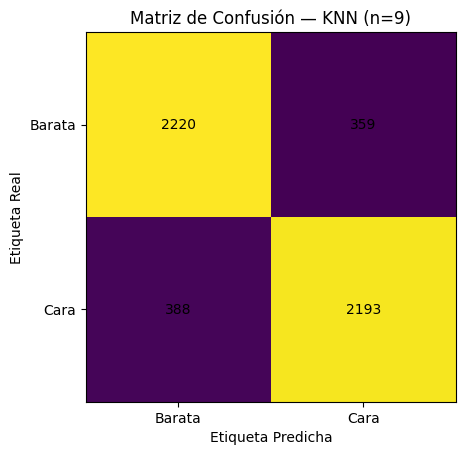

In [17]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Calcular matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Dibujar heatmap
fig, ax = plt.subplots()
ax.imshow(cm)

# Etiquetas en los ejes
ax.set_xticks([0, 1])
ax.set_xticklabels(['Barata', 'Cara'])
ax.set_yticks([0, 1])
ax.set_yticklabels(['Barata', 'Cara'])

# Anotar valores dentro de cada celda
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha='center', va='center')

ax.set_xlabel('Etiqueta Predicha')
ax.set_ylabel('Etiqueta Real')
ax.set_title('Matriz de Confusión — KNN (n=9)')

plt.show()



In [16]:
from sklearn.model_selection import GridSearchCV

# 1️⃣ Definir grid de hiperparámetros (valores impares entre 1 y 51)
param_grid = {"knn__n_neighbors": list(range(1, 52, 2))}

# 2️⃣ GridSearchCV sobre pipeline existente
grid = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

grid.fit(X_train, y_train)

# 3️⃣ Mejor k y su score en CV
best_k = grid.best_params_["knn__n_neighbors"]
best_cv_score = grid.best_score_
print(f"🔍 Mejor n_neighbors = {best_k} (CV accuracy = {best_cv_score:.3f})")

# 4️⃣ Evaluar en test con el modelo final
final_model = grid.best_estimator_
test_accuracy = final_model.score(X_test, y_test)
print(f"✅ Test accuracy con k={best_k}: {test_accuracy:.3f}")


🔍 Mejor n_neighbors = 9 (CV accuracy = 0.853)
✅ Test accuracy con k=9: 0.853


In [18]:
from sklearn.model_selection import cross_validate
import numpy as np

# Ejecutar CV (neg MAE porque scikit‑learn minimiza)
cv_results = cross_validate(
    pipeline, 
    X_train, 
    y_train, 
    scoring="neg_mean_absolute_error", 
    cv=5, 
    return_train_score=True
)

# Convertir scores negativos a MAE positivos
train_mae = -cv_results["train_score"]
test_mae  = -cv_results["test_score"]

print(f"► Train MAE: {train_mae.mean():.3f} ± {train_mae.std():.3f}")
print(f"► Test MAE:  {test_mae.mean():.3f} ± {test_mae.std():.3f}")

# Calcular accuracy equivalente
print(f"► Train Accuracy ≈ {1 - train_mae.mean():.3f}")
print(f"► Test Accuracy  ≈ {1 - test_mae.mean():.3f}")


► Train MAE: 0.131 ± 0.002
► Test MAE:  0.149 ± 0.007
► Train Accuracy ≈ 0.869
► Test Accuracy  ≈ 0.851
